In [1]:
import torch
import numpy as np
import dgl

import networkx as nx

import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
torch.cuda.device_count()

8

In [3]:
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

In [4]:
from dgl.nn.pytorch.conv import GraphConv
import torch.nn.functional as F

In [5]:
# Load data
data = np.load('QG_jets.npz')
X = data['X']
y = data['y']
print(X.shape)

(100000, 139, 4)


In [6]:
# Generate Graphs
def genGraph(event):
    tData = X[event][~np.all(X[event] == 0, axis=1)]
    # Preprocess feature by centering the jets and normalising the pT
    tData[:,1:3] -= np.average(tData[:,1:3], weights=tData[:,0], axis=0)
    tData[:, 0] /= np.sum(X[:, 0])
    tData = tData[tData[:,0].argsort()][::-1].copy()
    numNodes = tData.shape[0]
    
    tGraph = nx.complete_graph(numNodes)
    tGraph = dgl.from_networkx(tGraph)
    tGraph = dgl.add_self_loop(tGraph)
    tGraph.ndata['features'] = torch.tensor(tData)
    return tGraph.int()

In [8]:
size_limit = 3000
graphs = []
counter = 0
try:
    for i in range(min(len(X), size_limit)):
        graphs.append(genGraph(i))
        counter += 1
        if counter % 1000 == 0:
            print("Processed graph: ", counter)
except KeyboardInterrupt:
    pass

Processed graph:  1000
Processed graph:  2000
Processed graph:  3000


In [9]:
def display(graph):
    print("Graph with ", graph.number_of_nodes(), " nodes and ", graph.number_of_edges(), " edges.")
    nx.draw(graph.to_networkx())

Graph with  18  nodes and  324  edges.


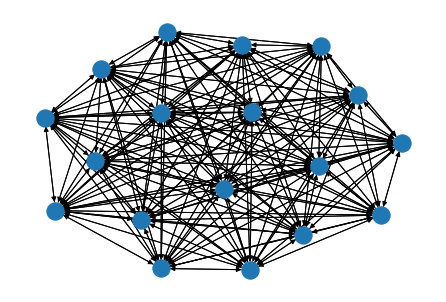

In [12]:
display(graphs[0])

In [13]:
sizes = (int(0.8* len(graphs)), int(0.1* len(graphs)), len(graphs)-int(0.9* len(graphs)))

In [14]:
print(sizes)

(2400, 300, 300)


In [15]:
dsTrain, dsVal, dsTest = torch.utils.data.random_split(list(zip(graphs, y)), sizes)
print("Train: ", len(dsTrain), "\nValidation: ", len(dsVal), "\nTest: ", len(dsTest))

Train:  2400 
Validation:  300 
Test:  300


In [16]:
trainDataGen = dgl.dataloading.GraphDataLoader(dsTrain, batch_size = sizes[0], drop_last=False, shuffle=True)
valDataGen = dgl.dataloading.GraphDataLoader(dsVal, batch_size = sizes[1], drop_last=False, shuffle=False)
testDataGen = dgl.dataloading.GraphDataLoader(dsTest, batch_size = sizes[2], drop_last=False, shuffle=False)

In [17]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, out_feats)
        self.bn1 = torch.nn.BatchNorm1d(num_features=hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(num_features=hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(num_features=out_feats)

    def forward(self, graph, h):
        h = F.relu(self.bn1(self.conv1(graph, h)))
        h = F.relu(self.bn2(self.conv2(graph, h)))
        h = F.relu(self.bn3(self.conv3(graph, h)))
        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        h = torch.sigmoid(h)
        h = (h-0.5) * 2
        return h

In [18]:
# Training function.
def train(model, optimizer, epochs=100, loss_func=torch.nn.MSELoss()):
    epoch_losses = {'train': [], 'val': []}
    for epoch in range(epochs):
        train_loss = 0
        for ibatch, (batched_graph, labels) in enumerate(trainDataGen):
            node_features = batched_graph.ndata['features']
            pred = model(batched_graph, node_features.float())
            loss = loss_func(pred, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().item()

        train_loss /= (ibatch + 1)

        epoch_losses['train'].append(train_loss)

        for ibatch, (batched_graph, labels) in enumerate(valDataGen):
            node_features = batched_graph.ndata['features']
            pred = model(batched_graph, node_features.float())
            val_loss = loss_func(pred, labels.float()).detach().item()
            epoch_losses['val'].append(val_loss)
            assert(ibatch == 0)
        print("Epoch: ", epoch+1, "\t Training Loss: ", train_loss, "\t Validation Loss:", val_loss)
        

    return epoch_losses

In [21]:
model = GCN(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_dim=9, out_feats=1)

In [22]:
history = train(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.1))

/lusnlsas/diat/anandw/.linuxbrew/opt/python@3.8/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2400])) that is different to the input size (torch.Size([2400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/lusnlsas/diat/anandw/.linuxbrew/opt/python@3.8/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  1 	 Training Loss:  0.45926305651664734 	 Validation Loss: 0.38786134123802185
Epoch:  2 	 Training Loss:  0.37437817454338074 	 Validation Loss: 0.3661763072013855
Epoch:  3 	 Training Loss:  0.3538920283317566 	 Validation Loss: 0.3484859764575958
Epoch:  4 	 Training Loss:  0.33937546610832214 	 Validation Loss: 0.3305249810218811
Epoch:  5 	 Training Loss:  0.32275885343551636 	 Validation Loss: 0.315915048122406
Epoch:  6 	 Training Loss:  0.30986663699150085 	 Validation Loss: 0.3134375512599945
Epoch:  7 	 Training Loss:  0.31150245666503906 	 Validation Loss: 0.3075641393661499
Epoch:  8 	 Training Loss:  0.30615904927253723 	 Validation Loss: 0.2960270345211029
Epoch:  9 	 Training Loss:  0.3004401624202728 	 Validation Loss: 0.2932964265346527
Epoch:  10 	 Training Loss:  0.29642945528030396 	 Validation Loss: 0.2921285927295685
Epoch:  11 	 Training Loss:  0.29661357402801514 	 Validation Loss: 0.291047602891922
Epoch:  12 	 Training Loss:  0.29638248682022095 	 Vali